# Bootstrap fit exploration

In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# catalogues to compare to
simard_df = pd.read_csv('lib/simard-catalog_fixed-n.csv', index_col=0)
simard_df_free = pd.read_csv('lib/simard-catalog_free-n.csv', index_col=0)
lackner_nb1 = pd.read_csv('lib/lackner_nb1.csv', index_col=0)
lackner_nb4 = pd.read_csv('lib/lackner_nb4.csv', index_col=0)

In [3]:
catalog_results = pd.concat((
  simard_df[['__B_T_r', 'e__B_T_r']]
    .rename(columns=dict(__B_T_r='Sbt', e__B_T_r='eSbt')),
  simard_df_free[['__B_T_r', 'e__B_T_r']]
    .rename(columns=dict(__B_T_r='Sbt_free', e__B_T_r='eSbt_free')),
  lackner_nb1[['BULGE_TO_TOT_R', 'BULGE_TO_TOT_R_ERR']]
    .rename(columns=dict(BULGE_TO_TOT_R='Lbt1', BULGE_TO_TOT_R_ERR='eLbt1')),
  lackner_nb4[['BULGE_TO_TOT_R', 'BULGE_TO_TOT_R_ERR']]
    .rename(columns=dict(BULGE_TO_TOT_R='Lbt4', BULGE_TO_TOT_R_ERR='eLbt4')),
), axis=1)

display_column_map = dict(
  Sbt='Exponential + De Vaucoulers\n(Simard, 2011)',
  Sbt_free='Exponential + Sersic\n(Simard, 2011)',
  Lbt1='Exponential + Exponential\n(Lackner, 2012)',
  Lbt4='Exponential + De Vaucoulers\n(Lackner, 2012)',
)

In [4]:
minima_info = {
    int(k.split('.')[0]): pd.read_csv(os.path.join('2comp_fits/minima', k), index_col=0)
    for k in os.listdir('2comp_fits/minima')
    if re.match(r'[0-9]+\.csv', k)
}

In [5]:
fracs_df = pd.DataFrame({
    k: v.query('accepted == True and bulge_frac > 0')['bulge_frac']
    for k, v in minima_info.items()
}).replace(0, np.nan)

In [6]:
errs = fracs_df.apply(np.nanstd)

/Users/tlingard/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [7]:
closest_index = np.abs(
    fracs_df - catalog_results['Lbt1'].reindex_like(fracs_df.T)
).idxmin().dropna()

In [8]:
mean_res = pd.Series([])
closest_res = pd.Series([])
for i in closest_index.index:
    mean_res[i] = fracs_df[i].mean()
    closest_res[i] = fracs_df[i][int(closest_index[i])]

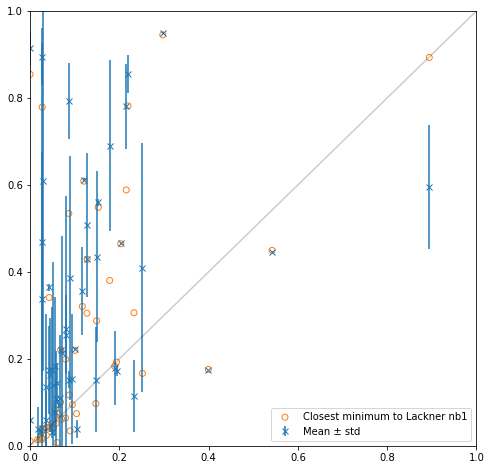

In [9]:
plt.figure(figsize=(8, 8))
plt.errorbar(catalog_results['Lbt1'].reindex_like(mean_res), mean_res, yerr=errs.reindex_like(mean_res), fmt='x', label='Mean ± std')
plt.scatter(catalog_results['Lbt1'].reindex_like(closest_res), closest_res, fc='none', ec='C1', label='Closest minimum to Lackner nb1')
plt.plot([0, 1], [0, 1], c='k', alpha=0.2)
plt.ylim(0., 1)
plt.xlim(0., 1)
plt.legend();

In [10]:
bulge_mux_df = pd.DataFrame({
    k: v.query('accepted == True and bulge_frac > 0')['bulge_dx']
    for k, v in minima_info.items()
})
bulge_muy_df = pd.DataFrame({
    k: v.query('accepted == True and bulge_frac > 0')['bulge_dy']
    for k, v in minima_info.items()
})

In [11]:
plt.figure(figsize=(12, 12))

mask = (bulge_offset < 2)
mean_res_masked = mean_res[mask]
closest_res_masked = closest_res[mask]
plt.errorbar(
    catalog_results['Lbt1'].reindex_like(mean_res_masked),
    mean_res_masked,
    yerr=errs.reindex_like(mean_res_masked),
    fmt='x'
)
plt.scatter(catalog_results['Lbt1'].reindex_like(closest_res_masked), closest_res_masked, fc='none', ec='C1')
plt.plot([0, 1], [0, 1], c='k', alpha=0.2)
plt.ylim(0., 1)
plt.xlim(0., 1)

NameError: name 'bulge_offset' is not defined

<Figure size 864x864 with 0 Axes>

In [12]:
import scipy.stats as st

In [20]:
st.norm.nnlf((0, 1), np.array([
    (params[i] - initial_params[i]) / param_sigma[i]
    for i in params.index
    if np.isfinite(param_sigma[i])
]))

3.6757541328186907

In [86]:
def negative_log_likelihood(
    render, target, sigma,
    params, initial_params, param_sigma
):
    # sum of likelihood from data and likelihood from priors
    scaled_diff = (target - render) / sigma
    render_nnlf = st.norm.nnlf((0, 1), scaled_diff.ravel())
    params_nnlf = st.norm.nnlf((0, 1), np.array([
        (params[i] - initial_params[i]) / param_sigma[i]
        for i in params.index
        if np.isfinite(param_sigma[i])
    ]))
    return render_nnlf + params_nnlf



In [87]:
shape = (100, 100)
params = pd.Series(np.zeros(4))
initial_params = pd.Series(np.zeros(4))
param_sigma = pd.Series(np.ones_like(params), params.index)
render = np.random.randn(*shape) / 100
target = np.zeros(shape)

In [91]:
negative_log_likelihood(render, target, 1, initial_params, initial_params, param_sigma)

9193.575224558748

In [94]:
negative_log_likelihood(render, target, 1, pd.Series([1, 0, 0, 0]), initial_params, param_sigma)

9198.075224558748